# Predicting Football Match Outcomes

### Introduction

This Python project aims to predict the outcome of football matches by predicting the expected goals a team will produce based on data known prior to the game related to team and opponent strength. 

The data is sourced from: https://beatthebookie.blog/download-excel-files/.

### Data Loading

In [199]:
import _sqlite3
import pandas as pd

# Loads in the data from the SQLite3 database
conn = _sqlite3.connect("data/historic_matches.db")
query = "SELECT DISTINCT * FROM match_data"
df = pd.read_sql_query(query, conn)


### Data Pre-processing

In [200]:
print(df.dtypes)

                         object
division_id              object
division                 object
season_id                object
season                   object
match_date               object
match_teams              object
home_team_id             object
home_team                object
away_team_id             object
away_team                object
home_num_players         object
home_market_value        object
home_avg_market_value    object
away_num_players         object
away_market_value        object
away_avg_market_value    object
home_goals               object
away_goals               object
home_shots               object
away_shots               object
home_shots_on_target     object
away_shots_on_target     object
home_corners             object
away_corners             object
home_yellow              object
away_yellow              object
home_red                 object
away_red                 object
home_xgoals              object
away_xgoals              object
home_dee

In [201]:
from sklearn.preprocessing import StandardScaler
# Transforms the datatypes of the columns in the dataframe. Also scales the numeric columns
df["match_date"] = pd.to_datetime(df["match_date"])
# creating a duplicate value of xG for the target variable (previous xG to be used as a feature)
df['home_xgoals_y'] = pd.to_numeric(df['home_xgoals'], errors='coerce')
df['away_xgoals_y'] = pd.to_numeric(df['away_xgoals'], errors='coerce')


numeric_cols = ["home_num_players", "home_market_value", "home_avg_market_value", "away_num_players", "away_market_value", "away_avg_market_value",
                "home_goals", "away_goals", "home_shots", "away_shots", "home_shots_on_target", "away_shots_on_target", "home_corners", "away_corners",
                "home_red", "away_red", "home_yellow", "away_yellow", "home_xgoals", "away_xgoals", "home_deep", "away_deep", "home_ppda", "away_ppda",
                "bet365_home_odds", "bet365_away_odds", "bet365_draw_odds", "bet365_u25_odds", "bet365_o25_odds"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols]) #Scaling the numeric columns

df["season"] = pd.to_numeric(df["season"].str[:4]) #converting season column to start year.

In [202]:
# Investigating nulls
null_counts = df.isnull().sum()
print(null_counts)


                             0
division_id                  0
division                     0
season_id                    0
season                       0
match_date                   0
match_teams                  0
home_team_id                 0
home_team                    0
away_team_id                 0
away_team                    0
home_num_players            64
home_market_value           64
home_avg_market_value       64
away_num_players            65
away_market_value           65
away_avg_market_value       65
home_goals                   3
away_goals                   3
home_shots                5218
away_shots                4838
home_shots_on_target      4838
away_shots_on_target      4838
home_corners              4838
away_corners              4838
home_yellow               4839
away_yellow               4837
home_red                  4837
away_red                  4837
home_xgoals               1244
away_xgoals               1244
home_deep                24225
away_dee

In [203]:
# Lots of the matches in the dataset are missing ppda/deep data, I want to use this is in the model so I will have to remove the matches that do not have this.
df = df.dropna(subset=["home_ppda"])
null_counts = df.isnull().sum()
print(null_counts)

                            0
division_id                 0
division                    0
season_id                   0
season                      0
match_date                  0
match_teams                 0
home_team_id                0
home_team                   0
away_team_id                0
away_team                   0
home_num_players            0
home_market_value           0
home_avg_market_value       0
away_num_players            0
away_market_value           0
away_avg_market_value       0
home_goals                  2
away_goals                  2
home_shots                383
away_shots                  3
home_shots_on_target        3
away_shots_on_target        3
home_corners                3
away_corners                3
home_yellow                 4
away_yellow                 3
home_red                    3
away_red                    3
home_xgoals                 0
away_xgoals                 0
home_deep                   0
away_deep                   0
home_ppda 

As you can see from above, we still have some missing values despite removing rows with missing ppda stats. Let's investigate this.

In [204]:
# Printing the season and division of rows with null for home_shots
missing_shots = df[df["home_shots"].isnull()]
print(missing_shots[["season", "division"]])

       season        division
7225     2018      Bundesliga
12116    2018         La Liga
25607    2016         Ligue 1
37078    2020  Premier League
37079    2020  Premier League
...       ...             ...
37453    2020  Premier League
37454    2020  Premier League
37455    2020  Premier League
37456    2020  Premier League
37457    2020  Premier League

[383 rows x 2 columns]


It appears that there are 3 random games from different seasons in 2018 and 2016, but there appears to be lots in the 2020 Premier League Seasons. I will now check to see if that is all of that season which means we can remove.

In [205]:
# Investigating nulls specifically in Premier League 2020 season
prem_2020 = df[(df["division"] == "Premier League") & (df["season"] == 2020)]
print(prem_2020.count())

                         380
division_id              380
division                 380
season_id                380
season                   380
match_date               380
match_teams              380
home_team_id             380
home_team                380
away_team_id             380
away_team                380
home_num_players         380
home_market_value        380
home_avg_market_value    380
away_num_players         380
away_market_value        380
away_avg_market_value    380
home_goals               380
away_goals               380
home_shots                 0
away_shots               380
home_shots_on_target     380
away_shots_on_target     380
home_corners             380
away_corners             380
home_yellow              380
away_yellow              380
home_red                 380
away_red                 380
home_xgoals              380
away_xgoals              380
home_deep                380
away_deep                380
home_ppda                380
away_ppda     

As you can see from above, the entire season is missing home shots, this presents an issue as the 2020 season is bang in the middle. Rather than removing that season from the dataset (as it would mess up future rolling avg calculations) I plan on estimating shots based on shots on target.

In [206]:
# Filtering data set to all Premier League seasons bar 2020 and working out the ratio of shots on target to shots.
prem_games = df[(df["division"] == "Premier League") & (df["season"] != 2020)]
shots = prem_games["home_shots"].sum() + prem_games["away_shots"].sum()
shots_on_target = prem_games["home_shots_on_target"].sum() + prem_games["away_shots_on_target"].sum()
shots_to_sot_ratio = (shots_on_target / shots)
print(shots_to_sot_ratio)

0.22872732184962788


In [207]:
# Now we have ratio, time to set shots for Prem 2020 season as an estimated value.
df.loc[(df["season"] == 2020) & (df["division"] == "Premier League"), "home_shots"] = (df["home_shots_on_target"] / shots_to_sot_ratio)

Now that season has been handled. For the remaining missig values I am just going to remove them from the dataset, as there are a few individual cases of missing goals (not replaeable by an estimate) and shots which will not have a large impact on the moving averages down the line as they are isolated.

In [208]:
df = df.dropna(subset=["home_shots"])
df = df.dropna(subset=["home_goals"])

print(df.isnull().sum())

                            0
division_id                 0
division                    0
season_id                   0
season                      0
match_date                  0
match_teams                 0
home_team_id                0
home_team                   0
away_team_id                0
away_team                   0
home_num_players            0
home_market_value           0
home_avg_market_value       0
away_num_players            0
away_market_value           0
away_avg_market_value       0
home_goals                  0
away_goals                  0
home_shots                  0
away_shots                  0
home_shots_on_target        0
away_shots_on_target        0
home_corners                0
away_corners                0
home_yellow                 1
away_yellow                 0
home_red                    0
away_red                    0
home_xgoals                 0
away_xgoals                 0
home_deep                   0
away_deep                   0
home_ppda 

So, we have removed nulls out of the features we plan to use. There are missing odds in the bet365 odds but for now we can leave these as they will not be used in training the model.

The last part of this stage of the project will be to unpivot the data set so that we don't have a home and away team for each match, but rather two rows of data for every match and we have a team and opponent. This is because I want to capture the home effect as a feature and not to build two separate models to capture home and away performance.

In [209]:
# Separates out the home vs away and allows every team to have an individual row of data. Allows us to feature engineer home effect easier.
home_df = df[["division", "season", "match_date",
             "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_xgoals", "home_xgoals_y", "home_deep", "home_ppda",
             "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_xgoals", "away_deep", "away_ppda"]].copy()
home_df["home?"] = 1
home_df = home_df.rename(columns={"home_team":"team", "home_avg_market_value":"avg_market_value", "home_goals":"goals",
             "home_shots":"shots", "home_xgoals":"xG", "home_xgoals_y":"xG_y", "home_deep":"deep", "home_ppda":"ppda",
             "away_team":"opponent_team", "away_avg_market_value":"opponent_avg_market_value", "away_goals":"opponent_goals", 
             "away_shots": "opponent_shots", "away_xgoals": "opponent_xG", "away_deep":"opponent_deep", "away_ppda":"opponent_ppda"})

away_df = df[["division", "season", "match_date",
                "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_xgoals", "away_xgoals_y", "away_deep", "away_ppda",
                "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_xgoals", "home_deep", "home_ppda"]].copy()
away_df["home?"] = 0
away_df = away_df.rename(columns={"away_team":"team", "away_avg_market_value":"avg_market_value", "away_goals":"goals",
             "away_shots":"shots", "away_xgoals":"xG", "away_xgoals_y": "xG_y", "away_deep":"deep", "away_ppda":"ppda",
             "home_team":"opponent_team", "home_avg_market_value":"opponent_avg_market_value", "home_goals":"opponent_goals", 
             "home_shots": "opponent_shots", "home_xgoals": "opponent_xG", "home_deep":"opponent_deep", "home_ppda":"opponent_ppda"})

df = pd.concat([away_df, home_df])
df.sort_values(["match_date", "division"], inplace=True)

### Exploratory Data Analysis

We are going to build a model for xG et's analyse both of this variable

count    36524.000000
mean         1.375438
std          0.868935
min          0.000000
25%          0.720000
50%          1.211050
75%          1.860000
max          6.880000
Name: xG_y, dtype: float64


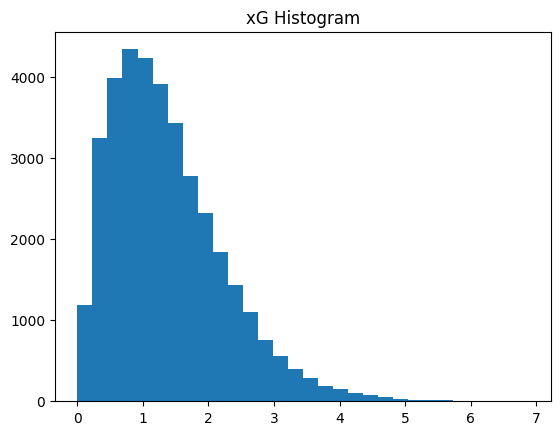

In [210]:
import matplotlib.pyplot as plt
print(df["xG_y"].describe())

plt.hist(df["xG_y"], bins=30)
plt.title("xG Histogram")
plt.show()
